In [1]:
import pandas as pd
import os
%pylab inline
import json
from pandas.io.json import json_normalize
import altair as alt
alt.renderers.enable('notebook', embed_options={'actions': True})

Populating the interactive namespace from numpy and matplotlib


RendererRegistry.enable('notebook')

In [2]:
json_results = []
folder="all_models_30_08_2019e/"
for f in os.listdir(folder):
    json_results.append(json.load(open(folder+f)))
df = pd.DataFrame(json_results)
df.columns=["horizon","method",2,3]
df["pred"]=df.apply(lambda row:row[2]["all"], axis=1)
df["target"]=df.apply(lambda row:row[2]["target"], axis=1)

In [3]:
def reliability_sharpness(pred, target):
    df = pd.DataFrame(pred)
    quantiles = np.arange(1,100)/100.0 
    df.columns = quantiles.astype(str)
    quantiles = np.arange(1,10)/10.0
    df["true"]=target
    
    # Reliability (should follow a line)
    counts=[]
    for quantile in quantiles.astype(str):
        counts.append(sum(df["true"]<df[quantile])/len(df))
        
    # Sharpness (should be all the same value)
    in_quantile=[sum(df["true"]<df["0.1"])/len(df)]
    for i in range(len(quantiles))[1:]:
        in_range = (df["true"]<df[str(quantiles[i])]) & (df["true"]>df[str(quantiles[i-1])])
        in_quantile.append(sum(in_range)/len(df) )
    in_quantile.append(sum(df["true"]>df["0.9"])/len(df))
    
    return counts, in_quantile

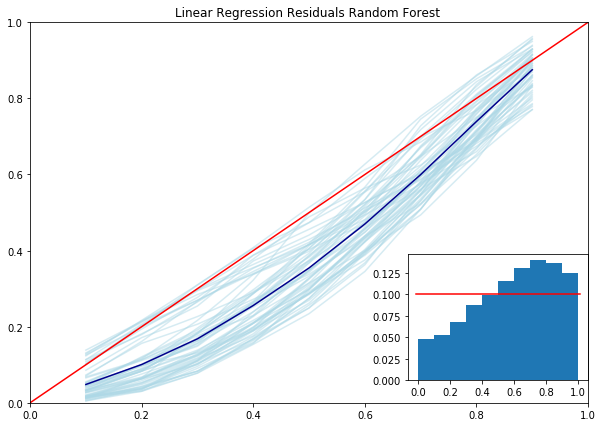

In [4]:
df["pred"]=df.apply(lambda row:row[2]["all"], axis=1)
df["target"]=df.apply(lambda row:row[2]["target"], axis=1)

method = "QRFL"

rels = []
sharps = []

for horizon in np.arange(1,60):
    pred = df[(df["horizon"]==horizon)&(df["method"]==method)]["pred"].iloc[0]
    target = df[(df["horizon"]==horizon)&(df["method"]==method)]["target"].iloc[0]
    
    rel, sharp = reliability_sharpness(pred,target)
    
    rels.append(rel)
    sharps.append(sharp)   
    

# Draw the average
quantiles = np.arange(1,10)/10.0
#Reliability Diagram
fig=plt.figure(figsize=(10,7))
plt.title("Linear Regression Residuals Random Forest ")
plt.gca().axes.set_xlim(0, 1)
plt.gca().axes.set_ylim(0, 1)
for rel in rels:
    plt.plot(quantiles,rel,alpha=0.5,color="lightblue")
plt.plot(quantiles,pd.DataFrame(rels).mean(),color="darkblue",alpha=1)
plt.plot([0,1],[0,1],c="red")

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.65, 0.17, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot([-0.01,1.01],[.1,.1],c="red")
ax2.bar(.05+np.arange(0,10)/10,pd.DataFrame(sharps).mean(),width=.1)


plt.show()

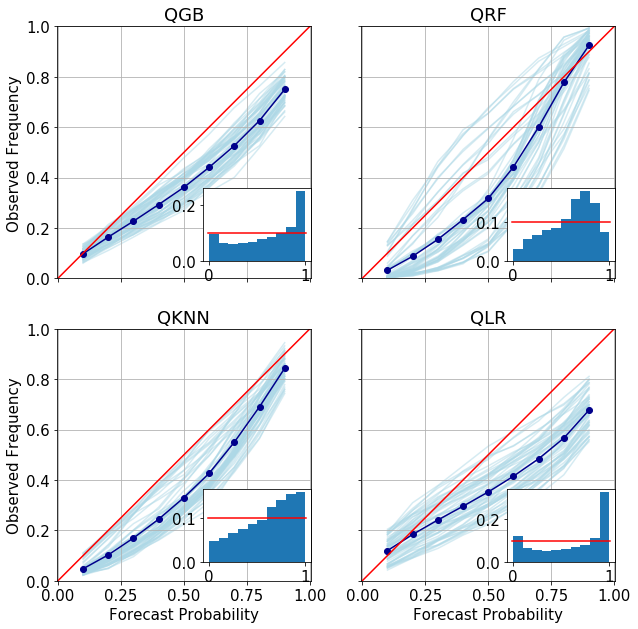

In [5]:
df["pred"]=df.apply(lambda row:row[2]["all"], axis=1)
df["target"]=df.apply(lambda row:row[2]["target"], axis=1)

method = "QRFL"

plt.rcParams.update({'font.size': 15})

def draw(method,title,x,y,left,bottom):
    rels = []
    sharps = []

    for horizon in np.arange(1,60):
        pred = df[(df["horizon"]==horizon)&(df["method"]==method)]["pred"].iloc[0]
        target = df[(df["horizon"]==horizon)&(df["method"]==method)]["target"].iloc[0]

        rel, sharp = reliability_sharpness(pred,target)

        rels.append(rel)
        sharps.append(sharp)   


    # Draw the average
    quantiles = np.arange(1,10)/10
    #Reliability Diagram
    plt.title(title)
    plt.axis('equal');
    plt.gca().axes.set_xlim(0, 1)
    plt.gca().axes.set_ylim(0, 1)
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)
    for rel in rels:
        plt.plot(quantiles,rel,alpha=0.5,color="lightblue",zorder=-1)
    plt.plot(quantiles,pd.DataFrame(rels).mean(),color="darkblue",alpha=1)
    plt.scatter(quantiles,pd.DataFrame(rels).mean(),color="darkblue",alpha=1,zorder=2)
    plt.plot([0,1],[0,1],c="red")
    if bottom:
        plt.xlabel("Forecast Probability")
    if left:
        plt.ylabel("Observed Frequency")
        
    plt.tick_params(labelleft=left, labelbottom=bottom,)

    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [x, y, 0.15, 0.1]
    ax2 = fig.add_axes([left, bottom, width, height])

    ax2.plot([-0.01,1.01],[.1,.1],c="red")
    ax2.bar(.05+np.arange(0,10)/10,pd.DataFrame(sharps).mean(),width=.1)
    

fig=plt.figure(figsize=(10,10.2))
plt.subplot(2,2,1)
draw("QGB","QGB",0.328,0.56,True,False)
plt.subplot(2,2,2)
draw("QRF","QRF",0.75,.56,False,False)
plt.subplot(2,2,3)
draw("QKNN","QKNN",.328,0.15,True,True)
plt.subplot(2,2,4)
draw("QLR","QLR",.75,.15,False,True)

In [6]:
# Let's draw the predictions at a certain time
from all_data_preprocessing_9 import *
df_orig = get_data("data/dataEscAgui.csv")
indices_test = []
for horizon in tqdm(np.arange(1,60)):
    X_train, X_test, y_train, y_test = prepare_data_from_horizon(df_orig,int(horizon))
    indices_test.append(X_test.index.copy())

100%|██████████| 59/59 [00:08<00:00,  9.36it/s]


In [7]:
X_train.shape

(34859, 102)

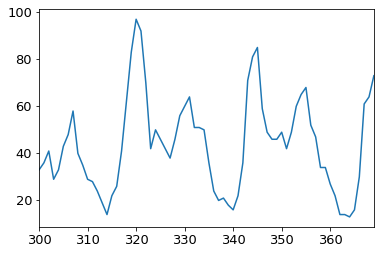

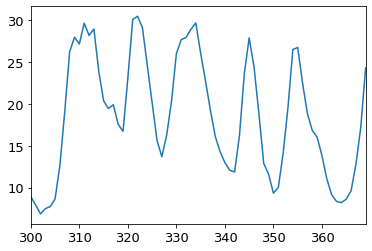

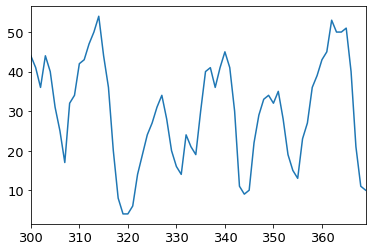

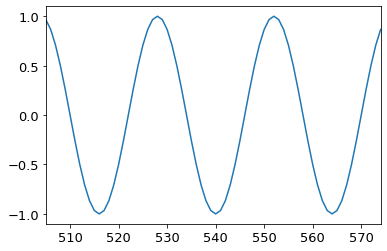

In [31]:
np.exp(df_orig["NO2"])[300:370].plot(kind="line")
plt.show()
np.exp(df_orig["MACC.NO2.Lon35625_Lat4035_Lead0"])[300:370].plot(kind="line")
plt.show()
df_orig["O3"][300:370].plot(kind="line")
plt.show()
X_train["c1461"][300:370].plot(kind="line")

In [8]:
import seaborn as sns

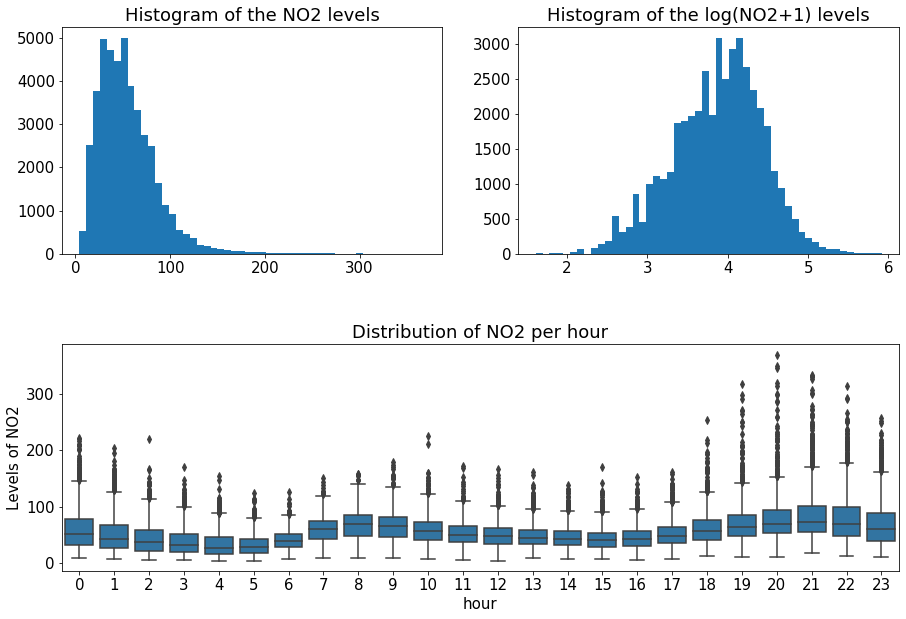

In [9]:
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.4)


plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})
plt.subplot(grid[0, 0])
plt.title("Histogram of the NO2 levels")
plt.hist(np.exp(df_orig["NO2"])-1,bins=50)

plt.subplot(grid[0, 1])
plt.title("Histogram of the log(NO2+1) levels")
plt.hist(df_orig["NO2"],bins=50)

plt.subplot(grid[1:3, :2])
temp_df = df_orig.copy()
temp_df["hour"]=temp_df["date"].dt.hour
temp_df["NO2"]=np.exp(temp_df["NO2"])
sns.boxplot(data=temp_df, x="hour",y="NO2",color="#1f77b4")
plt.title("Distribution of NO2 per hour")
plt.ylabel("Levels of NO2")
plt.show()

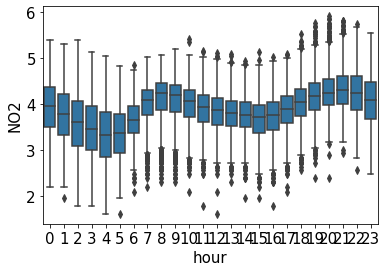

In [10]:
temp_df = df_orig.copy()
temp_df["hour"]=temp_df["date"].dt.hour
sns.boxplot(data=temp_df, x="hour",y="NO2",color="#1f77b4")

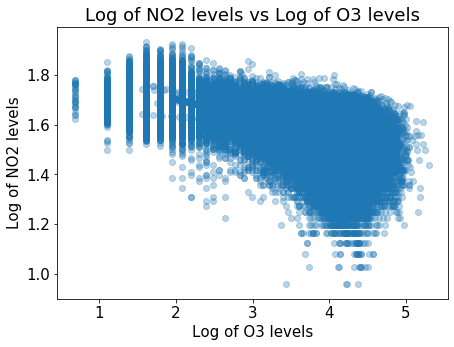

In [11]:
plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 15})

plt.title("Log of NO2 levels vs Log of O3 levels")
plt.xlabel("Log of O3 levels")
plt.ylabel("Log of NO2 levels")
plt.scatter(np.log1p(df_orig["O3"]),np.log1p(df_orig["NO2"]),alpha=.3)
plt.show()

In [12]:
from colour import Color

red = Color("#c6e3f9")
blue = Color("#B19CD9")
colors = list(red.range_to(blue, 50))

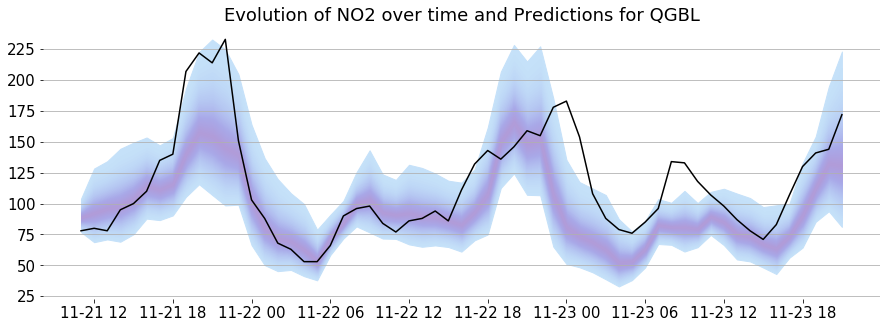

In [81]:
# Start_time
start = df_orig[df_orig["date"].dt.strftime("%Y-%m-%d %H:%M")=="2017-09-09 10:00"].index[0]
start = df_orig[df_orig["date"].dt.strftime("%Y-%m-%d %H:%M")=="2017-11-21 10:00"].index[0]
method="QGBL"
horizon=1

preds=[]
targets=[]
for horizon in np.arange(1,60):
    pos=np.where(np.array(indices_test[horizon-1])==start+horizon)[0][0]
    
    pred = df[(df["horizon"]==horizon)&(df["method"]==method)]["pred"].iloc[0][pos]
    preds.append(pred)
    
    target = df[(df["horizon"]==horizon)&(df["method"]==method)]["target"].iloc[0][pos]
    targets.append(target)


fig = plt.figure(figsize=(15,5))
plt.box(on=False)
plt.gca().yaxis.grid(True)
plt.rcParams.update({'font.size': 15})
plt.title(f"Evolution of NO2 over time and Predictions for {method}") 


hours = df_orig["date"].loc[start+1:start+59]
for i in np.arange(1,50):
    plt.fill_between(hours, np.array(preds)[:,i], np.array(preds)[:,-i],color=colors[i].get_rgb())


#plt.plot(df_orig.loc[start:start+num]["date"],np.exp(df_orig.loc[start:start+num]["NO2"])+1)
plt.plot(hours,targets,color="black")
plt.rcParams.update({'font.size': 15});

In [82]:
from scipy import stats

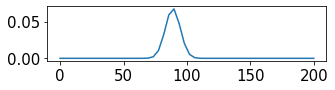

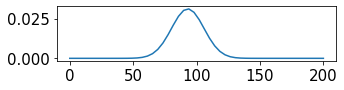

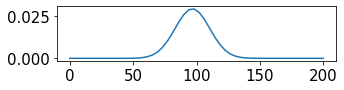

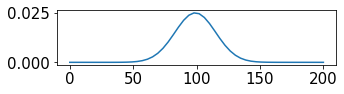

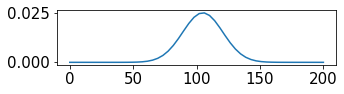

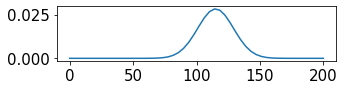

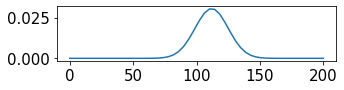

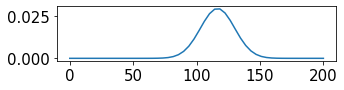

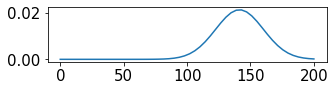

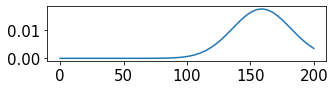

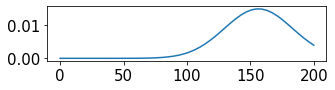

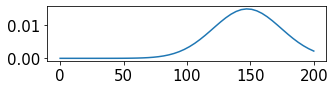

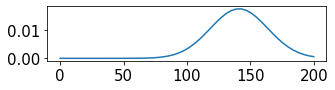

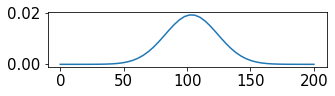

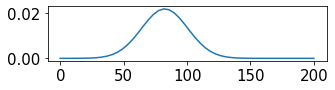

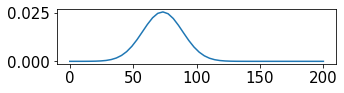

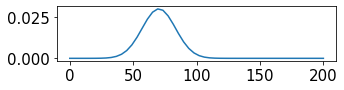

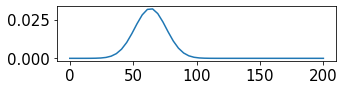

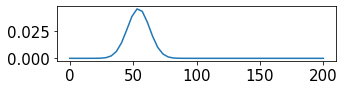

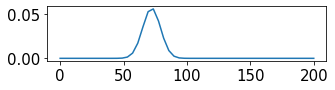

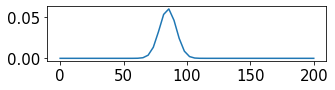

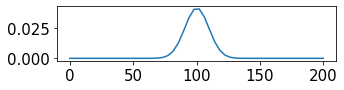

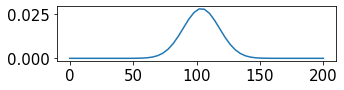

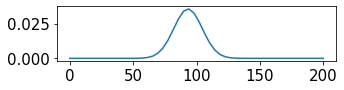

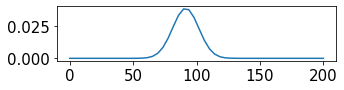

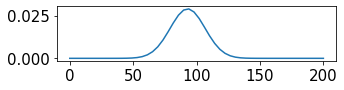

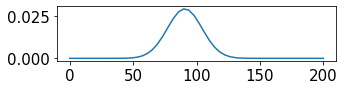

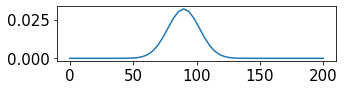

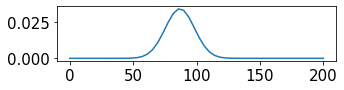

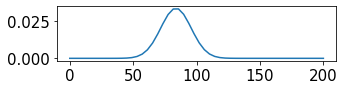

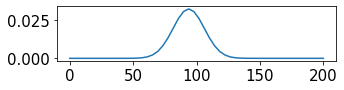

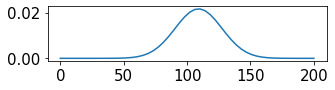

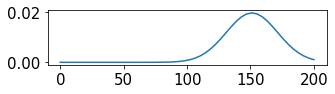

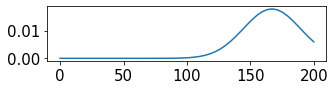

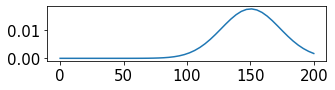

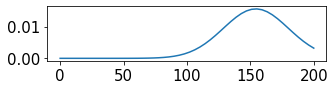

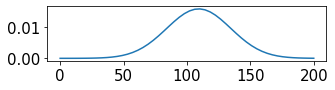

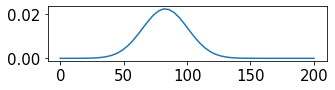

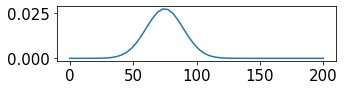

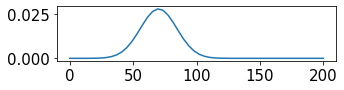

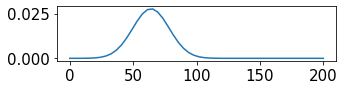

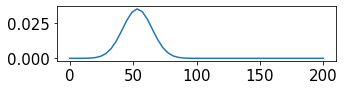

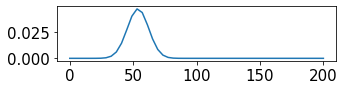

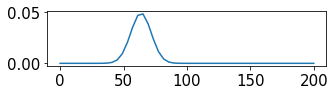

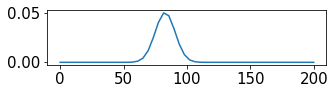

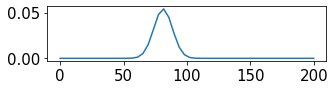

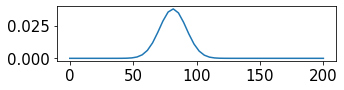

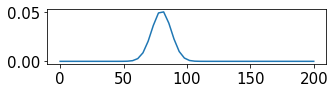

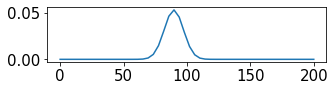

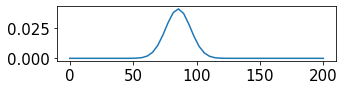

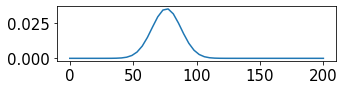

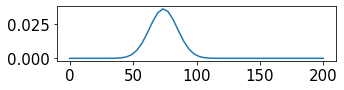

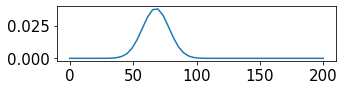

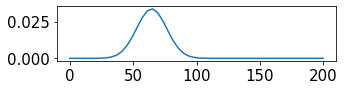

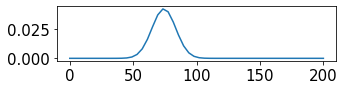

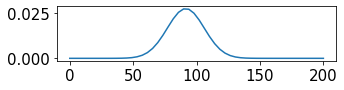

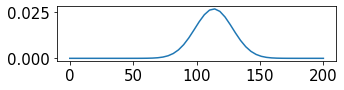

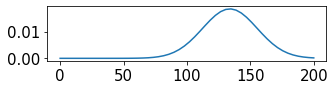

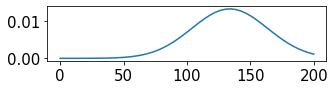

In [83]:
for i in range(59):
    plt.figure(figsize=(5,1))
    minorm=stats.norm(*stats.norm.fit(preds[i]))
    x=np.linspace(0,200)
    plt.plot(x,minorm.pdf(x))
    plt.show();

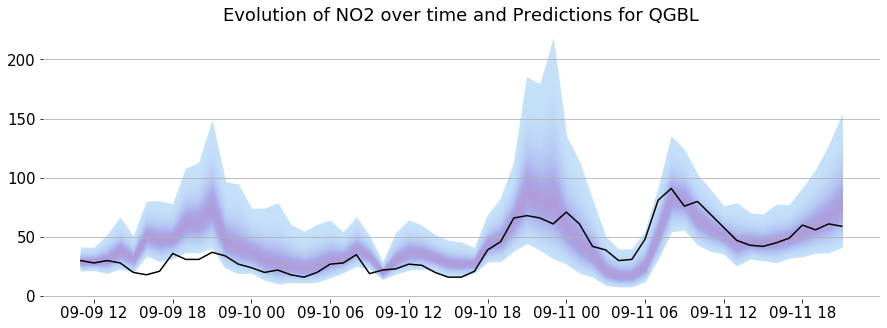

In [14]:
# Start_time
start = df_orig[df_orig["date"].dt.strftime("%Y-%m-%d %H:%M")=="2017-09-09 10:00"].index[0]
method="QGBL"
horizon=1

preds=[]
targets=[]
for horizon in np.arange(1,60):
    pos=np.where(np.array(indices_test[horizon-1])==start+horizon)[0][0]
    
    pred = df[(df["horizon"]==horizon)&(df["method"]==method)]["pred"].iloc[0][pos]
    preds.append(pred)
    
    target = df[(df["horizon"]==horizon)&(df["method"]==method)]["target"].iloc[0][pos]
    targets.append(target)


fig = plt.figure(figsize=(15,5))
plt.box(on=False)
plt.gca().yaxis.grid(True)
plt.rcParams.update({'font.size': 15})
plt.title(f"Evolution of NO2 over time and Predictions for {method}") 


hours = df_orig["date"].loc[start+1:start+59]
for i in np.arange(1,50):
    plt.fill_between(hours, np.array(preds)[:,i], np.array(preds)[:,-i],color=colors[i].get_rgb())


#plt.plot(df_orig.loc[start:start+num]["date"],np.exp(df_orig.loc[start:start+num]["NO2"])+1)
plt.plot(hours,targets,color="black")
plt.rcParams.update({'font.size': 15});

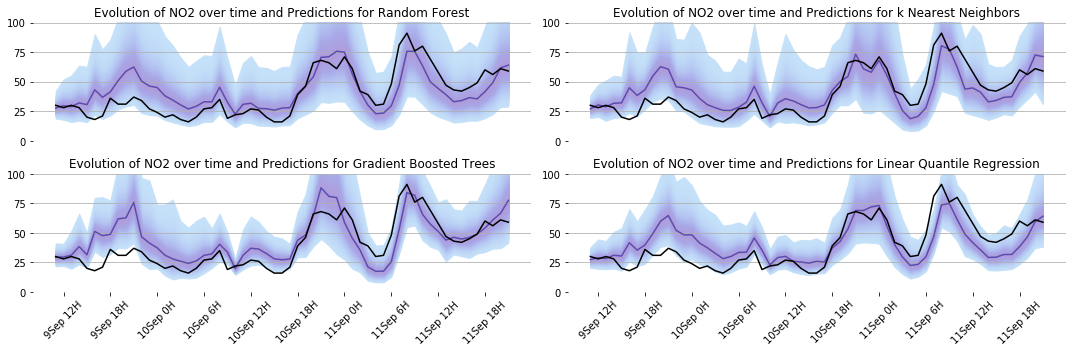

In [15]:
import matplotlib.dates as mdates

# Start_time
start = df_orig[df_orig["date"].dt.strftime("%Y-%m-%d %H:%M")=="2017-09-09 10:00"].index[0]

def draw(method,title,bottom):
    
    preds=[]
    targets=[]
    for horizon in np.arange(1,60):
        pos=np.where(np.array(indices_test[horizon-1])==start+horizon)[0][0]

        pred = df[(df["horizon"]==horizon)&(df["method"]==method)]["pred"].iloc[0][pos]
        preds.append(pred)

        target = df[(df["horizon"]==horizon)&(df["method"]==method)]["target"].iloc[0][pos]
        targets.append(target)

    plt.box(on=False)
    plt.gca().yaxis.grid(True)
    
    plt.title(f"Evolution of NO2 over time and Predictions for {title}") 

    hours = df_orig["date"].loc[start+1:start+59]
    for i in np.arange(1,50):
        plt.fill_between(hours, np.array(preds)[:,i], np.array(preds)[:,-i],color=colors[i].get_rgb())
    plt.plot(hours, np.array(preds)[:,50],color="darkblue",alpha=0.5)
    plt.plot(hours,targets,color="black")
    plt.gca().axes.set_ylim(0, 1.1*np.max(targets))
    fmt = mdates.DateFormatter('%-d%b %-HH')
    plt.gca().xaxis.set_major_formatter(fmt)
    plt.xticks(rotation=45)
    plt.tick_params(bottom=bottom, labelbottom=bottom)
    plt.tight_layout()


fig = plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 10})
plt.subplot(2,2,1)
draw("QRFL","Random Forest",False)
plt.subplot(2,2,2)
draw("QKNNL","k Nearest Neighbors",False)
plt.subplot(2,2,3)
draw("QGBL","Gradient Boosted Trees",True)
plt.subplot(2,2,4)
draw("QLR","Linear Quantile Regression",True)

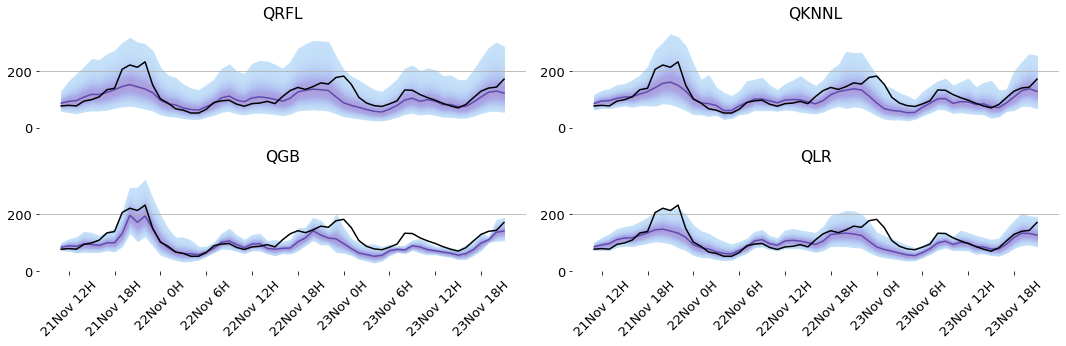

In [16]:
import matplotlib.dates as mdates

# Start_time
start = df_orig[df_orig["date"].dt.strftime("%Y-%m-%d %H:%M")=="2017-09-09 10:00"].index[0]
start = df_orig[df_orig["date"].dt.strftime("%Y-%m-%d %H:%M")=="2017-11-21 10:00"].index[0]

max_total=0
for method in ["QRFL","QKNNL","QGBL","QLR"]:
    for horizon in np.arange(1,60):
        pos=np.where(np.array(indices_test[horizon-1])==start+horizon)[0][0]
        pred = df[(df["horizon"]==horizon)&(df["method"]==method)]["pred"].iloc[0][pos]
        max_total = np.max([np.max(pred),max_total])

def draw(method,title,bottom):
    
    preds=[]
    targets=[]
    for horizon in np.arange(1,60):
        pos=np.where(np.array(indices_test[horizon-1])==start+horizon)[0][0]

        pred = df[(df["horizon"]==horizon)&(df["method"]==method)]["pred"].iloc[0][pos]
        preds.append(pred)

        target = df[(df["horizon"]==horizon)&(df["method"]==method)]["target"].iloc[0][pos]
        targets.append(target)

    plt.box(on=False)
    plt.gca().yaxis.grid(True)
    
    plt.title(f"{title}") 

    hours = df_orig["date"].loc[start+1:start+59]
    for i in np.arange(1,50):
        plt.fill_between(hours, np.array(preds)[:,i], np.array(preds)[:,-i],color=colors[i].get_rgb())
    plt.plot(hours, np.array(preds)[:,50],color="darkblue",alpha=0.5)
    plt.plot(hours,targets,color="black")
    plt.gca().axes.set_ylim(0, 1.1*max_total)
    fmt = mdates.DateFormatter('%-d%b %-HH')
    plt.gca().xaxis.set_major_formatter(fmt)
    plt.xticks(rotation=45)
    plt.tick_params(bottom=bottom, labelbottom=bottom)
    plt.tight_layout()


fig = plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 13})
plt.subplot(2,2,1)
draw("QRFL","QRFL",False)
plt.subplot(2,2,2)
draw("QKNNL","QKNNL",False)
plt.subplot(2,2,3)
draw("QGB","QGB",True)
plt.subplot(2,2,4)
draw("QLR","QLR",True)

In [17]:
df_orig[df_orig["NO2"]>np.log1p(180)][["date","NO2"]]

,date,NO2
5062,2013-07-30 23:00:00,5.342334
5063,2013-07-31 00:00:00,5.342334
6117,2013-09-12 22:00:00,5.361292
6118,2013-09-12 23:00:00,5.252273
8085,2013-12-03 21:00:00,5.379897
...,...,...
43536,2017-12-20 00:00:00,5.313206
43556,2017-12-20 20:00:00,5.288267
43557,2017-12-20 21:00:00,5.361292
43604,2017-12-22 20:00:00,5.236442


In [18]:
X_test.index

Int64Index([35085, 35109, 35133, 35157, 35181, 35205, 35229, 35253, 35277,
            35301,
            ...
            44373, 44397, 44421, 44445, 44469, 44493, 44517, 44541, 44565,
            44589],
           dtype='int64', length=397)

In [19]:
df_test = df_orig[df_orig["day"]>"2016"].copy()

In [20]:
# There are 121 instances where the levels of NO2 were above the levels
len(df_test[df_test["NO2"]>np.log1p(180)])

121

In [21]:
from sklearn.metrics import classification_report, roc_auc_score, precision_score

method="QGBL"

# We have this for each horizon
results = []
temp=[]

horizon = 13
index_test = indices_test[horizon-1]

#nbr_alerts
temp.append( sum(df_orig.loc[index_test]["NO2"]>np.log1p(180)) )

pred = df[(df["horizon"]==horizon)&(df["method"]==method)]["pred"].values[0]
target = df[(df["horizon"]==horizon)&(df["method"]==method)]["target"].values[0]

def get_perc(row):
    if (row.iloc[0]>180): return 1
    srow=row
    try:
        return 1-(srow[srow<180].index[-1])/100
    except:
        return 0
    
pdf = pd.DataFrame(pred)
pdf.columns = np.arange(1,100)

print(sum(pdf.apply(get_perc,axis=1)>.5))
pred_proba = pdf.apply(get_perc,axis=1)
target = (np.array(target)>180).astype(int)
print(classification_report(target,pred_proba>.5))
print(roc_auc_score(target,pred_proba))

# Detected alerts
temp.append(precision_score(target,pred_proba>.5)*sum(pdf.apply(get_perc,axis=1)>.5))

# False Positive
temp.append(precision_score(target,pred_proba>.5)*sum(pdf.apply(get_perc,axis=1)>.5)-sum(pdf.apply(get_perc,axis=1)>.5))

temp

0


/home/sebas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sebas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.97      1.00      0.99       387
           1       0.00      0.00      0.00        10

    accuracy                           0.97       397
   macro avg       0.49      0.50      0.49       397
weighted avg       0.95      0.97      0.96       397

0.7361757105943154


[10, 0.0, 0.0]

In [22]:
from sklearn.metrics import classification_report, roc_auc_score, precision_score

method="QGB"

# We have this for each horizon
results = []

for horizon in tqdm(np.arange(1,60)):
    temp=[]

    index_test = indices_test[horizon-1]

    #nbr_alerts
    temp.append( sum(df_orig.loc[index_test]["NO2"]>np.log1p(180)) )

    pred = df[(df["horizon"]==horizon)&(df["method"]==method)]["pred"].values[0]
    target = df[(df["horizon"]==horizon)&(df["method"]==method)]["target"].values[0]

    def get_perc(row):
        if (row.iloc[0]>180): return 1
        srow=row
        try:
            return 1-(srow[srow<180].index[-1])/100
        except:
            return 0

    pdf = pd.DataFrame(pred)
    pdf.columns = np.arange(1,100)

    #print(sum(pdf.apply(get_perc,axis=1)>.5))
    pred_proba = pdf.apply(get_perc,axis=1)
    target = (np.array(target)>180).astype(int)
    #print(classification_report(target,pred_proba>.5))
    #print(roc_auc_score(target,pred_proba))

    # Detected alerts
    temp.append(precision_score(target,pred_proba>.5)*sum(pdf.apply(get_perc,axis=1)>.5))

    # False Positive
    temp.append(precision_score(target,pred_proba>.5)*sum(pdf.apply(get_perc,axis=1)>.5)-sum(pdf.apply(get_perc,axis=1)>.5))
    temp.append(precision_score(target,pred_proba>.5))
    results.append(temp)

100%|██████████| 59/59 [00:51<00:00,  1.16it/s]


In [23]:
from sklearn.metrics import classification_report, roc_auc_score, precision_score

def get_detection(method):
    # We have this for each horizon
    results = []

    for horizon in tqdm(np.arange(1,60)):
        temp=[]

        index_test = indices_test[horizon-1]

        #nbr_alerts
        threshold = 180
        
        temp.append( sum(df_orig.loc[index_test]["NO2"]>np.log1p(threshold)) )

        pred = df[(df["horizon"]==horizon)&(df["method"]==method)]["pred"].values[0]
        target = df[(df["horizon"]==horizon)&(df["method"]==method)]["target"].values[0]

        
        
        def get_perc(row):
            if (row.iloc[0]>threshold): return 1
            srow=row
            try:
                return 1-(srow[srow<threshold].index[-1])/100
            except:
                return 0

        pdf = pd.DataFrame(pred)
        pdf.columns = np.arange(1,100)

        #print(sum(pdf.apply(get_perc,axis=1)>.5))
        pred_proba = pdf.apply(get_perc,axis=1)
        target = (np.array(target)>threshold).astype(int)
        #print(classification_report(target,pred_proba>.5))
        #print(roc_auc_score(target,pred_proba))

        # Detected alerts
        temp.append(precision_score(target,pred_proba>.5)*sum(pdf.apply(get_perc,axis=1)>.5))

        # False Positive
        temp.append(precision_score(target,pred_proba>.5)*sum(pdf.apply(get_perc,axis=1)>.5)-sum(pdf.apply(get_perc,axis=1)>.5))
        temp.append(precision_score(target,pred_proba>.5))
        results.append(temp)
        
    rdf = pd.DataFrame(results)
    rdf.columns=["true_num","true_pos","false_pos","precision"]
    for col in rdf.columns:
        rdf[col]=rdf[col].astype(int)
        
    return rdf

In [24]:
rdf_qrf = get_detection("QRFL")
rdf_qknn = get_detection("QKNNL")
rdf_qgb = get_detection("QGB")
rdf_qlr = get_detection("QLR")

 68%|██████▊   | 40/59 [00:33<00:16,  1.16it/s]

KeyboardInterrupt: 

In [ ]:
rdf_combined = pd.DataFrame()
rdf_combined["Number of alerts"]=rdf_qrf["true_num"]

rdf_combined["QGB detection"]=rdf_qgb["true_pos"]
rdf_combined["QGB false positives"]=rdf_qgb["false_pos"]
rdf_combined["QLR detection"]=rdf_qlr["true_pos"]
rdf_combined["QLR false positives"]=rdf_qlr["false_pos"]
rdf_combined["QKNNL detection"]=rdf_qknn["true_pos"]
rdf_combined["QKNNL false positives"]=rdf_qknn["false_pos"]
rdf_combined["QRFL detection"]=rdf_qrf["true_pos"]
rdf_combined["QRFL false positives"]=rdf_qrf["false_pos"]

rdf_combined[(rdf_combined["Number of alerts"]!=0)]

In [ ]:
print(rdf_combined[(rdf_combined["Number of alerts"]!=0)].to_latex())